In [1]:
import netket as nk
from numpy.lib.function_base import append
from itertools import permutations, combinations
from netket.vqs.mc import get_local_kernel_arguments, get_local_kernel
import time
import matplotlib.pyplot as plt
import json
import numpy as np
from numpy.linalg import eig
from flax.core.frozen_dict import FrozenDict
import flax
from netket.optimizer.qgt import QGTJacobianPyTree


from typing import Callable, Tuple
from functools import partial

import jax
from jax import numpy as jnp

from netket.stats import statistics as mpi_statistics, mean as mpi_mean, Stats
from netket.utils.types import PyTree
from netket.operator.spin import sigmax, sigmay,sigmaz

import matplotlib.pyplot as plt
from tqdm import tqdm
################################################################
from scipy.sparse.linalg import eigsh
################################################################
import os
import pandas as pd



In [13]:
# We always shorten netket as nk
import netket as nk

# Define a 1d chain
L = 8
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)
# ha = nk.operator.Heisenberg(hilbert=hi, graph=g)
dis=1
b=dis
a=-dis
Gamma = (b-a) * np.random.random_sample(L) + a

ha = sum([ sigmax(hi,i)*sigmax(hi,(i+1)%L)
         + sigmay(hi,i)*sigmay(hi,(i+1)%L)
         + sigmaz(hi,i)*sigmaz(hi,(i+1)%L)
           for i in range(L)])
################################################################################
################################################################################
################################################################################
ha = ha + sum([Gamma[i]*sigmaz(hi,i) for i in range(L)])

In [24]:
Et = np.random.randint(low=0, high=L, size=None)
# Et = np.random.randint(0,L, size=1)
# Et = 9
Et


1

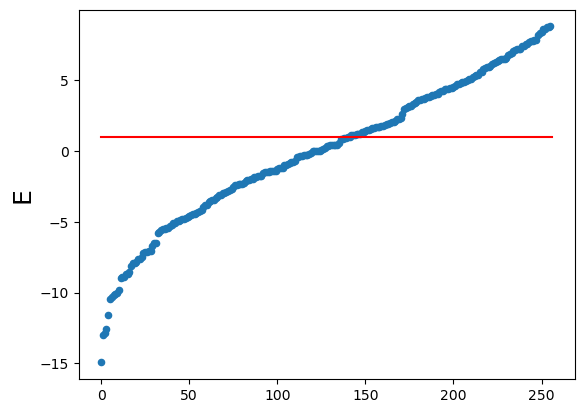

In [25]:
E, vec = np.linalg.eigh(ha.to_dense())
plt.scatter(np.arange(len(E)),E,s=20)
plt.ylabel('E',fontsize=18)
plt.plot([0,len(E)],[Et,Et],'r')

In [26]:
E

array([-1.49405868e+01, -1.29644285e+01, -1.28590014e+01, -1.25538855e+01,
       -1.15534752e+01, -1.04242938e+01, -1.02857526e+01, -1.01686951e+01,
       -1.00849183e+01, -1.00505691e+01, -9.82099764e+00, -8.99958837e+00,
       -8.91788806e+00, -8.89663975e+00, -8.67951606e+00, -8.66127618e+00,
       -8.51847207e+00, -8.11994673e+00, -7.90332937e+00, -7.87918361e+00,
       -7.84100114e+00, -7.62447691e+00, -7.61285856e+00, -7.50849728e+00,
       -7.21546046e+00, -7.15710324e+00, -7.14019885e+00, -7.09642676e+00,
       -7.06698731e+00, -6.69061231e+00, -6.50699840e+00, -6.48693557e+00,
       -5.76292994e+00, -5.73734590e+00, -5.60356800e+00, -5.53781237e+00,
       -5.49848840e+00, -5.45215424e+00, -5.41790102e+00, -5.29209641e+00,
       -5.19500504e+00, -5.07047969e+00, -5.06768599e+00, -4.96736717e+00,
       -4.93194068e+00, -4.85222188e+00, -4.77684046e+00, -4.77312373e+00,
       -4.75601006e+00, -4.66401939e+00, -4.59853334e+00, -4.52298817e+00,
       -4.41914167e+00, -

In [27]:
# and like before, we can jit-compile it!
# compute_energy_jit = jax.jit(compute_energy, static_argnames="model")

# and we precompute the sparse-hamiltonian to avoid the overhead of re-computing them all the time
# hamiltonian_jax = ha.to_pauli_strings().to_jax_operator()
# hamiltonian_sparse = hamiltonian.to_sparse()
# hamiltonian_jax_sparse = hamiltonian_jax.to_sparse()

hamil_Et_jax = (ha-Et).to_pauli_strings().to_jax_operator()
hamil_Et_jax_sparse = hamil_Et_jax.to_sparse()

hamil_Et_sq_jax = ((ha-Et)@(ha-Et)).to_pauli_strings().to_jax_operator()
hamil_Et_sq_jax_sparse = hamil_Et_sq_jax.to_sparse()

The model itself is only a set of instructions on how to initialise the parameters and how to compute the result. 

To initialise the parameters we do the following:

In [28]:
def to_array(model, parameters):
    # begin by generating all configurations in the hilbert space.
    # all_States returns a batch of configurations that is (hi.n_states, N) large.
    all_configurations = hi.all_states()

    # now evaluate the model, and convert to a normalised wavefunction.
    logpsi = model.apply(parameters, all_configurations)
    psi = jnp.exp(logpsi)
    psi = psi / jnp.linalg.norm(psi)
    return psi

### 3.3 Energy
Now, using that function, let's build another one that computes the energy of the mean field state for the given parameters! 
To do that, you can for example convert the hamiltonian to a sparse format and compute the energy

In [29]:
def compute_energy(model, parameters, hamil):
    psi_gs = to_array(model, parameters)
    return psi_gs.conj().T@(hamil@psi_gs)

def loss_fun(model, pre_psi, parameters, ha_Et, ha_Et_sq):
    psi_gs = to_array(model, parameters)
    return psi_gs.conj().T@(ha_Et_sq@psi_gs) - 2*pre_psi.conj().T@(ha_Et@psi_gs)
    # return psi_gs.conj().T@(ha_Et_sq@psi_gs)/(psi_gs.conj()@psi_gs) - 2*pre_psi.conj().T@(ha_Et@psi_gs)/(pre_psi.conj()@psi_gs)
    # return psi_gs.conj().T@(ha_Et_sq@psi_gs)
    
def compute_variance(model, parameters, hamil):
    psi_gs = to_array(model, parameters)
    variance = psi_gs.conj().T@(hamil@hamil@psi_gs) - (psi_gs.conj().T@(hamil@psi_gs))**2 
    return variance

In [30]:
from functools import partial

# we use partial to directly jit this function. Jitting the top-most will jit everything inside it as well.
@partial(jax.jit, static_argnames='model')
def compute_and_gradient(model, pre_psi, parameters, ha_Et, ha_Et_sq):
    # grad_fun = jax.value_and_grad(compute_energy, argnums=1)
    grad_fun = jax.jacfwd(loss_fun, argnums=2,holomorphic=True)
    # grad_fun = jax.jacrev(loss_fun, argnums=2,holomorphic=True)
    return grad_fun(model, pre_psi, parameters, ha_Et, ha_Et_sq)

In [31]:
model = nk.models.RBM(alpha=2, param_dtype=complex)

parameters = model.init(jax.random.PRNGKey(0), np.ones((hi.size, )))

# logging: you can (if you want) use netket loggers to avoid writing a lot of boilerplate...
# they accumulate data you throw at them
logger = nk.logging.RuntimeLog()
energy = []
from tqdm import tqdm
import optax

# define
optimizer = optax.adam(learning_rate=0.001)

# initialise
optimizer_state = optimizer.init(parameters)

# for i in range(n_iters):
#     E, E_grad = estimate_energy_and_grad(..., parameters, ...)
    
#     updates, optimizer_state = optimizer.update(E_grad, optimizer_state, parameters)
#     parameters = optax.apply_updates(parameters, updates)


for i in tqdm(range(10000)):
    # compute energy and gradient
    # energy, gradient = compute_energy_and_gradient(model, parameters, hamiltonian_jax_sparse)
    pre_psi = to_array(model, parameters)
    energy.append(compute_energy(model, parameters, ha))
    gradient = compute_and_gradient(model, pre_psi, parameters, hamil_Et_jax_sparse, hamil_Et_sq_jax_sparse)
    updates, optimizer_state = optimizer.update(gradient, optimizer_state, parameters)
    # update parameters
    # parameters = jax.tree.map(lambda x,y:x-0.01*y, parameters, gradient)
    parameters = optax.apply_updates(parameters, updates)
    
    # log energy: the logger takes a step argument and a dictionary of variables to be logged
    # logger(step=i, item={'Energy':energy})

    
compute_variance(model, parameters, ha)    

100%|█████████████████████████████████████| 10000/10000 [09:45<00:00, 17.08it/s]


Array(5.98486319-2.62947911e-15j, dtype=complex128)

In [32]:
psi_ = to_array(model, parameters)
psi_.conj().T@(ha@ha@psi_) - (psi_.conj().T@(ha@psi_))**2 

Array(5.98486319-2.62947911e-15j, dtype=complex128)

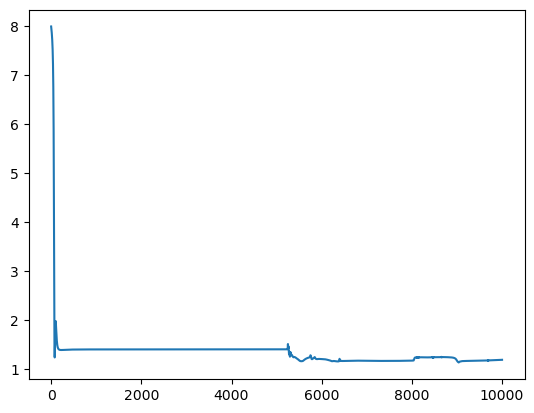

In [33]:
plt.plot(np.real(energy))
# plt.xlim([2500,2510])

In [ ]:
energy[-1]